# Read in a csv file from exoplanets.org 
# and allow some simple comparisons.

In [25]:
% matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 5
from matplotlib.font_manager import FontProperties
import scipy.integrate as integrate
import csv
import math
import numpy as np
import pylab as p
import constants as cs
#import my_fns

# For magnitude lookups
from astroquery.irsa import Irsa
import astropy.units as u

In [2]:
import astropy.constants as c
print c.M_earth


  Name   = Earth mass
  Value  = 5.97236473042e+24
  Uncertainty  = 2.77406483954e+20
  Unit  = kg
  Reference = IAU 2015 Resolution B 3 + CODATA 2014


In [3]:
# Constants in SI units
Msun, Rsun = 1.99E30, 6.96E8
Mjup, Rjup = 1.90E27 ,6.99E7
Mearth, Rearth = 5.972e24, 6.371e6
au = 1.496e+11
mproton = 1.673E-27
h = 6.62607004e-34
c = 299792458
k = 1.38064852e-23
G = 6.67408e-11

### Need to add in missing magnitudes from TEPCat

In [4]:
from astroquery.simbad import Simbad
#Simbad.list_votable_fields()  # list of possible fields that you can request. 

customSimbad = Simbad()

# see which fields are currently set
print(customSimbad.get_votable_fields())

# To set other fields
customSimbad.add_votable_fields('mk', 'sp', 'flux(V)','flux(B)', 'flux(R)','flux(I)', 'flux(J)','flux(K)',
                               "flux_error(V)", "flux_error(B)", "flux_error(R)", "flux_error(I)",
                                "flux_error(J)", "flux_error(J)")  
# add the photometric fields, and also the spectral type fields. 

print(customSimbad.get_votable_fields())
result_table = customSimbad.query_object("HAT-P-1")
print(result_table.colnames)
print(result_table['FLUX_K'])
print(result_table['SP_TYPE'])

######################################################################


from astroquery.irsa import Irsa
import astropy.units as u

#print(Irsa.list_catalogs())

table = Irsa.query_region("HAT-P-1", catalog="fp_psc", spatial="Cone",   
                               radius=0.1 * u.arcsec)
# IRSA won't let you query an object, so query the very small region near object. 
#The point source catalog of 2MASS is 'fp_psc'.
print(table.colnames)
print('Jmag = ' + str(table['j_m'][0]) )
print('Hmag = ' + str(table['h_m'][0]) )
print('Kmag = ' + str(table['k_m'][0]) )

['main_id', 'coordinates']
['main_id', 'coordinates', 'mk', 'sp', 'flux(V)', 'flux(B)', 'flux(R)', 'flux(I)', 'flux(J)', 'flux(K)', 'flux_error(V)', 'flux_error(B)', 'flux_error(R)', 'flux_error(I)', 'flux_error(J)', 'flux_error(J)']
['MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA', 'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH', 'COO_BIBCODE', 'MK_ds', 'MK_mss', 'MK_Spectral_type', 'MK_bibcode', 'SP_TYPE', 'FLUX_V', 'FLUX_B', 'FLUX_R', 'FLUX_I', 'FLUX_J', 'FLUX_K', 'FLUX_ERROR_V', 'FLUX_ERROR_B', 'FLUX_ERROR_R', 'FLUX_ERROR_I', 'FLUX_ERROR_J', 'FLUX_ERROR_J_1']
FLUX_K
 mag  
------
 8.858
SP_TYPE
-------
    G0V
['ra', 'dec', 'clon', 'clat', 'err_maj', 'err_min', 'err_ang', 'designation', 'j_m', 'j_cmsig', 'j_msigcom', 'j_snr', 'h_m', 'h_cmsig', 'h_msigcom', 'h_snr', 'k_m', 'k_cmsig', 'k_msigcom', 'k_snr', 'ph_qual', 'rd_flg', 'bl_flg', 'cc_flg', 'ndet', 'gal_contam', 'mp_flg', 'hemis', 'xdate', 'scan', 'glon', 'glat', 'a', 'dist_opt', 'phi_opt', 'b_m_opt'

In [5]:
# Here is a snippet similar to the previous ones to query the AllWISE Source Catalog. L-band is approximately W1, M-band is ~W2.

from astroquery.irsa import Irsa
import astropy.units as u


## 'AllWISE Source Catalog'
table = Irsa.query_region("HAT-P-1", catalog='allwise_p3as_psd', spatial="Cone",
                               radius=1 * u.arcsec)
print(table.colnames)
print('W1mag = ' + str(table['w1mpro'][0]) )
print('W2mag = ' + str(table['w2mpro'][0]) )
print('W3mag = ' + str(table['w3mpro'][0]) )
print('W4mag = ' + str(table['w4mpro'][0]) )



#BTW: if you want to try another 2MASS or WISE, or any IR catalog, basically, you can run this:
#print(Irsa.list_catalogs())
#and find the catalog you want to use. I hope this helps.

['designation', 'ra', 'dec', 'clon', 'clat', 'sigra', 'sigdec', 'sigradec', 'w1mpro', 'w1sigmpro', 'w1snr', 'w1rchi2', 'w2mpro', 'w2sigmpro', 'w2snr', 'w2rchi2', 'w3mpro', 'w3sigmpro', 'w3snr', 'w3rchi2', 'w4mpro', 'w4sigmpro', 'w4snr', 'w4rchi2', 'nb', 'na', 'w1sat', 'w2sat', 'w3sat', 'w4sat', 'pmra', 'sigpmra', 'pmdec', 'sigpmdec', 'cc_flags', 'ext_flg', 'var_flg', 'ph_qual', 'moon_lev', 'w1nm', 'w1m', 'w2nm', 'w2m', 'w3nm', 'w3m', 'w4nm', 'w4m', 'dist', 'angle', 'id']
W1mag = 8.732
W2mag = 8.751
W3mag = 8.624
W4mag = 8.37


### Reading function

'System': name

'Teff': Effective temperature (K)

'[Fe/H]': Metallicity (dex)

'M_A': Mass of the star (Msun)

'R_A': Radius of star (Rsun)

'loggA': log surface gravity of the star (cgs)

'rho_A': density of star (rhosun)

'Period': (days)

'e': eccentricity

'a(AU)': separation (AU)

'M_b': Mass of planet (Mjup)

'R_b': Radius of planet (Rjup)

'g_b': Planet gravity (m/s^2)

'rho_b': Density (rhojup)

'Teq': Equilibrium Temperature (K)

'Discovery_reference': Discovery

'Recent_reference': Latest reference

In [6]:
def read_exodata(csv_file='allplanets-tepcat.csv'):
    '''
    Read in csv file from TEPCat
    First read and output header as a list
    
    Then read each line in csv, splitting and putting in a dict
    using the header values as keys
    '''
    with open(csv_file, 'r') as g:
        reader = csv.reader(g, delimiter=',')
        header = [ name.strip() for name in reader.next() ]
        #units = reader.next()
        yield header
        for row in reader:

            store = []
            for el in row:
                el = el.strip()
                try: el = float(el)
                except ValueError: pass #leave string
                store.append(el)
            row = store
        
            data_dict = dict(list(zip(header, row)))
            yield data_dict

In [7]:
def get_arrays(exo_data, hnames=['System', 'Teff', '[Fe/H]', 'M_A', 'R_A', 'loggA', 'rho_A', 'Period', \
                           'e', 'a(AU)', 'M_b', 'R_b', 'g_b', 'rho_b', 'Teq', \
                           'Discovery_reference', 'Recent_reference'], \
              need=['System']):
    '''
    Returns a dictionary of the requested parameter arrays, 
    dictionary contains all the parameters listed in hnames
    Only need to change hnames if changing the format of the csv 
    or using a different catalogue
    
    exo_data: read_exodata(csv_file) - list of dictionaries
    need: specifies parameters required, if a planet lacks a parameter in need 
                it is skipped and the name is placed in rejects
                
    Can put some other constraints on planet params here, e.g. Mass > 0
    but TEPCat is pretty solid
    '''
    rejects = []
    
    out_dict = {}
    for i in range(len(hnames)):
        out_dict[hnames[i]] = []
        
    for line in exo_data:
        # check that we have all hnames
        need_vals = [ line[hname] for hname in need ]
        #if np.any([ val == -1. for val in need_vals]): 
        #    rejects.append(line['System'])
        #    continue
        try:
            vals = [ line[hname] for hname in hnames ]
        except KeyError: # value missing
            continue

        for i in range(len(hnames)): out_dict[hnames[i]].append(vals[i])
            
    for i in range(len(hnames)):
        out_dict[hnames[i]] = np.array(out_dict[hnames[i]])
      
    #print 'Rejects:', rejects
    return out_dict

In [8]:
def get_planet(name, od):
    # get dictionary of one planet's parameters from csv dictionary
    try: names = list(od['NAME'])
    except KeyError: names = list(od['System'])
    ind = names.index(name)
    return dict([ (var, od[var][ind]) for var in od if var != 'rejects'])

In [9]:
def get_tepcat_planets(bands_2mass=['J','H','K']):
    '''
    Combine TEPCatalogues of well studied planets and observables
    basically just to include V and K mags in dictionary
    
    Just use this to read in the data
    '''
    exo_data = read_exodata('allplanets-tepcat.csv')
    header = exo_data.next()
    od = get_arrays(exo_data, need=['System', 'M_b', 'R_b', 'Teq', 'a(AU)', 'R_A', 'Period'])
    
    exo_data2 = read_exodata('observables_tepcat.csv')
    header = exo_data2.next()
    od2 = get_arrays(exo_data2, hnames=['System', 'Vmag', 'Kmag'])
    
    od['Vmag'] = np.ones(len(od['System']))*-1
    od['Kmag'] = np.ones(len(od['System']))*-1
    
    od_names = list(od['System'])
    od2_names = list(od2['System'])
    for i1, name in enumerate(od['System']):
        try: 
            i2 = od2_names.index(name)
            od['Vmag'][i1] = od2['Vmag'][i2]
            od['Kmag'][i1] = od2['Kmag'][i2]
        except ValueError: 
            pass
    
    # Attempt at 2MASS lookup
    for name in od['System']:
        continue
        try:
            #print(Irsa.list_catalogs())
            print
            print name,
            if name == '55_Cnc_e': qname = '2MASS J08523579+2819509'
            else: qname = name
                
            qname = ' '.join(qname.split('_'))
            if qname[-1] in ['a','b','c','d','e','f','g']: qname = qname[:-1]
            if qname != name: print qname
            else: print
            
            # IRSA won't let you query an object, so query the very small region near object. 
            # The point source catalog of 2MASS is 'fp_psc'.
            table = Irsa.query_region(qname, catalog="fp_psc", spatial="Cone",    
                                           radius=0.1 * u.arcsec)
            print('Jmag = ' + str(table['j_m'][0]) )
            print('Hmag = ' + str(table['h_m'][0]) )
            print('Kmag = ' + str(table['k_m'][0]) )
        except IndexError:
            print 'Failed lookup'
        except Exception:
            print 'Malformed coordinate/object name'
    return od

### Test TEPCat

In [10]:
print get_planet('Kepler-444d', od)['TEQ']
print get_planet('Kepler-444e', od)['TEQ']

print get_planet('Kepler-444d', od)['Teq']
print get_planet('Kepler-444e', od)['Teq']

NameError: name 'od' is not defined

In [11]:
od = get_tepcat_planets()

print get_planet('Kepler-078', od)

{'loggA': 4.61, 'rho_A': 2.0, 'Teff': 5121.0, 'rho_b': 4.5, 'M_b': 0.0059, 'M_A': 0.83, 'Vmag': 11.75, 'Kmag': 9.59, 'System': 'Kepler-078', 'Period': 0.355, 'a(AU)': 0.0089, '[Fe/H]': -0.08, 'R_A': 0.74, 'Teq': -1.0, 'R_b': 0.107, 'Recent_reference': '2015ApJ...808..127G', 'g_b': 11.4, 'e': 0.0, 'Discovery_reference': '2013ApJ...774...54S'}


### Plotting function

In [12]:
def plot_arrays(x, y, z=None, xlabel='', ylabel='', zlabel='', title='', names=None, vmin=None, vmax=None, 
                invert_z=False, show=True, txmin=None, txmax=None, tymin=None, tymax=None,
                ylim=None, xlim=None, fontsize=None):
    # For making quick plots of certain parameters / SNRs
    p.scatter(x, y, marker='o', c=z, cmap='hot_r', vmin=vmin, vmax=vmax)
    if not names is None:
        font0 = FontProperties()
        font1 = font0.copy()
        if not fontsize is None: font1.set_size(fontsize)
        for xi, yi, ni in zip(x,y,names):
            if xi < txmin and not txmin is None: continue
            elif xi > txmax and not txmax is None: continue
            elif yi < tymin and not tymin is None: continue
            elif yi > tymax and not tymax is None: continue
            if not xlim is None:
                if xi < xlim[0] or xi > xlim[1]: continue
            if not ylim is None:
                if yi < ylim[0] or yi > ylim[1]: continue
            p.text(xi,yi,ni, fontproperties=font1)
                
    p.xlabel(xlabel)
    p.ylabel(ylabel)
    p.title(title)
    if not xlim is None: p.xlim(xlim)
    if not ylim is None: p.ylim(ylim)
    if not z is None:
        cbar = p.colorbar()
        cbar.set_label(zlabel)
        if invert_z: cbar.ax.invert_xaxis()
    if show: p.show()
 
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label, HoverTool

def plot_html(od, xname='M_b', yname='R_b', size=8, fname=None, x_range=None, y_range=None, title=None,
              keys=['M_b', 'R_b', 'Teq', 'Period', 'Vmag', 'Kmag', 'M_A', 'R_A', 'Teff', 'e']):
    
    source = ColumnDataSource(data=od)
    
    tools = "pan,wheel_zoom,box_zoom,reset,save".split(',')
    
    keys = keys
    if xname in keys: keys.remove(xname)
    if yname in keys: keys.remove(yname)

    tooltips=[ ("Name", "@System"),(xname+':', "@"+xname),(yname+':', "@"+yname)]
    tooltips += [ (key+':', '@'+key) for key in keys]
    
    hover = HoverTool(tooltips=tooltips)
    tools.append(hover)

    plt = figure(tools=tools, title=title, x_range=x_range, y_range=y_range)

    plt.scatter(x=xname, y=yname, source=source, size=size)
    plt.xaxis.axis_label = xname
    plt.yaxis.axis_label = yname
    if fname: save(plt, fname)
    show(plt)

Loading BokehJS ...

In [13]:
print od.keys()

['Discovery_reference', 'Recent_reference', 'rho_A', 'Teff', 'rho_b', 'M_b', 'M_A', 'Vmag', 'Kmag', 'System', 'Period', 'a(AU)', '[Fe/H]', 'Teq', 'R_A', 'R_b', 'loggA', 'e', 'g_b']


In [14]:
plot_html(od, xname='M_b', yname='TSNR_K', x_range=(-0.1,3), y_range=(0,20),
          title='Test', fname='/home/jacob/Desktop/test.html')

/home/jacob/anaconda2/lib/python2.7/site-packages/bokeh/io.py:423: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warnings.warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/jacob/anaconda2/lib/python2.7/site-packages/bokeh/io.py:433: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warnings.warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


### Table function

In [15]:
def table_arrays(headers, arrays, savefile='table.txt', sort=None, reverse=False, units=None):
    # Save results to a table
    #my_fns.silentremove(savefile)
    with open(savefile, 'w') as g:
        g.write('\t\t'.join(headers)+'\n')
        if not units is None: g.write('\t\t'.join(units)+'\n')
        if sort:
            i = headers.index(sort)
            _, indexes = zip(*sorted(zip(arrays[i], np.arange(len(arrays[i]))),reverse=reverse))
            indexes = [int(i) for i in indexes]
            arrays = [np.array(array)[indexes] for array in arrays]
        lines = ['\t\t'.join([str(item) for item in things])+'\n' for things in zip(*arrays)]
        for line in lines:
            g.write(line)      
    return

In [67]:
import csv

def csv_arrays(fname, od, keys, names=None, units=['-'], formats=['{}'], sort='System', reverse=True):
    if names is None: names=keys
    with open(fname, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=keys)
        names_dict = {}
        for key, val in zip(keys, names): names_dict[key] = val
        writer.writerow(names_dict)
        units_dict = {}
        for key, val in zip(keys, units): units_dict[key] = val
        writer.writerow(units_dict)
        
        indexes = np.argsort(od[sort])
        if reverse: indexes = reversed(indexes)
            
        for i in indexes:
            name = od['System'][i]
            planet = get_planet(name, od)
            
            # check values make sense, otherwise skip
            vals = [val for val in planet.values() if not type(val) in [str, np.str]]
            print zip(vals, [type(val) for val in vals])
            if not np.all(np.isfinite(vals)): continue # this planet is missing something  
                
            row = {}
            for key, form in zip(keys, formats): row[key] = form.format(planet[key])
            writer.writerow(row)
            

In [74]:
#print od['System']
print get_planet('HATS-06', od)

{'EDE_5mu': 1810.1431681549404, 'System': 'HATS-06', 'EESNR_5mu': 24.854209210503832, 'g_b': 7.9, 'EDE_10mu': 3047.0004747591756, 'Vmag': 15.16, 'M_A': 0.574, 'Kmag': 11.22, 'a(AU)': 0.03623, 'EESNR_10mu': 17.573266825808837, 'TEQ': 857.6812879111321, 'loggA': 4.683, 'Discovery_reference': '2015AJ....149..166H', 'rho_b': 0.301, 'Teq': 713.0, 'M_b': 0.319, 'rho_A': 3.09, 'R_b': 0.998, 'Recent_reference': '2015AJ....149..166H', 'e': 0.0, 'Teff': 3770.0, 'g': 8.307200333061491, 'Period': 3.325, '[Fe/H]': 0.2, 'R_A': 0.57}


### Calculations

#### For transmission

In [17]:
def calc_eq_temp(a, Ts, Rs, A=0, f_redist=2.):
    '''Assume parameters in SI units'''
    # f_redist = 2 for no redistribution
    # f_redist = 1 for full day-night redistribution
    return np.sqrt(np.divide(Rs,a)/f_redist)*Ts*(2**0.25) * (1-A)**0.25

def calc_surface_g(M, R):
    '''Returns surface g in SI'''
    G = 6.67E-11
    return G*M/R**2

def calc_scale_h(T,g,mu=1.2):
    '''
    Calculate atmospheric scale height,
    data should be in SI units.
    '''
    k = 1.38064852E-23
    return k*T/g/(mu*mproton)

def calc_transit_depth(sh, Rp, Rs, nsh=1):
    return 2*nsh*sh*Rp/(Rs**2)

def weins_peak(T):
    b = 2.8977729e-3 # m/K
    return b/T*1e6 # in micron

#### For emission

In [18]:
def bb(l, T):
    # the energy per unit time (or the power) radiated per unit area of emitting surface 
    # in the normal direction per unit solid angle by a black body at temperature T at wavelength l
    h = 6.62607004E-34; c = 2.99792458E8; k = 1.38064852E-23 # S.I. units
    return 2*h*c**2 / l**5 / (np.exp(h*c/l/k/T)-1)

def bb_flux(T, R, band=(1e-6,2e-6)):
    # calculate flux in units of J/s in a given band
    if band == 'V':
        l1, l2 = (551-88)*10**-9, (551+88)*10**-9
    elif band == 'B':
        l1, l2 = (445-47)*10**-9, (445+47)*10**-9
    elif band == 'J':
        l1, l2 = (1.235-0.081)*10**-6, (1.235+0.081)*10**-6
    elif band == 'H':
        l1, l2 = (1.662-0.1255)*10**-6, (1.662+0.1255)*10**-6
    elif band == 'K':
        l1, l2 = (2.159-0.131)*10**-6, (2.159+0.131)*10**-6
    elif band == 'G102':
        l1, l2 = .800*10**-6, 1.150*10**-6
    elif band == 'G141':
        l1, l2 = 1.075*10**-6, 1.700*10**-6
    elif band == 'Spitzer1':
        l1, l2 = 3.1*10**-6, 4.1*10**-6
    else:
        l1, l2 = band
    I, error = integrate.quad(bb, l1, l2, args=T)
    F = I*np.pi*R**2 * np.pi #pi solidangle, piR^2 area
    return F

def eclipse_depth(Tp, Ts, Rp, Rs, band):
    try:
        Fp = np.array([ bb_flux(tp, rp, band) for tp, rp in zip(Tp, Rp)])
        Fs = np.array([ bb_flux(ts, rs, band) for ts, rs in zip(Ts, Rs)])
    except TypeError: # not iterable
        Fp = bb_flux(Tp, Rp, band)
        Fs = bb_flux(Ts, Rs, band) # J/s
    return Fp/Fs

def reflected_depth(Ts, Rp, Rs, a, band, A=1):
    try:
        Fs = np.array([ bb_flux(ts, rs, band) for ts, rs in zip(Ts, Rs)])
    except TypeError: # not iterable
        Fs = bb_flux(Ts, Rs, band)
    Fp = Fs * (Rp/a/2)**2 * A
    return Fp/Fs

def reflected_depth_quick(Rp,a,A):
    # Fp/Fs is just geometry in this case
    return (Rp/a/2)**2 *A

def emission_over_reflection(Tp, Ts, Rp, Rs, a, l, A=1):
    # calculate the emitted/relected flux for given parameters at a given wavelength
    # Note: albedo for reflected component may not be the same as that used 
    # to calculate eq temperature.
    try:
        Fp_ref = (Rp/a/2)**2 * A * np.array([ bb(l,ts) for ts in Ts ])
        Fp_em = np.array([bb(l,tp) for tp in Tp])
    except TypeError:
        Fp_ref = (Rp/a/2)**2 * A * bb(l,Ts)
        Fp_em = bb(l,Tp)
    return Fp_em/Fp_ref

def reflected_frac(Tp, Ts, Rp, Rs, a, l, A=1):
    # calculate the fraction of relected flux for given parameters at a given wavelength
    # Note: albedo for reflected component may not be the same as that used 
    # to calculate eq temperature.
    try:
        Fp_ref = (Rp/a/2)**2 * A * np.array([ bb(l,ts) for ts in Ts ])
        Fp_em = np.array([bb(l,tp) for tp in Tp])
    except TypeError:
        Fp_ref = (Rp/a/2)**2 * A * bb(l,Ts)
        Fp_em = bb(l,Tp)
    return Fp_ref/(Fp_ref+Fp_em)

# Look at specific planets

In [19]:
od = get_tepcat_planets()

od['g'] = calc_surface_g(od['M_b']*Mjup, od['R_b']*Rjup)
od['TEQ'] = calc_eq_temp(od['a(AU)']*au, od['Teff'], od['R_A']*Rsun, A=0)
od['SH'] = calc_scale_h(od['TEQ'], od['g'])

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide


In [20]:
W18 = get_planet('WASP-018', od)
print W18

{'M_b': 10.52, 'System': 'WASP-018', 'g_b': 179.9, 'Vmag': 9.27, 'M_A': 1.295, 'Kmag': 8.13, 'a(AU)': 0.02055, 'TEQ': 2868.6479133793505, 'loggA': 4.353, 'Discovery_reference': '2009Natur.460.1098H', 'rho_b': 5.64, 'R_A': 1.255, 'rho_A': 0.655, 'R_b': 1.204, 'Recent_reference': '2013MNRAS.428.2645M', 'e': 0.0092, 'Teff': 6400.0, 'g': 188.22956966846345, 'Period': 0.941, 'SH': 104808.21951499172, '[Fe/H]': 0.1, 'Teq': 2411.0}


In [21]:
for planet in ['HD_189733', 'HD_209458', 'WASP-012', 'WASP-121', 'WASP-069', 'WASP-080', 'WASP-043',\
              'WASP-017', 'WASP-039', 'WASP-019', 'HAT-P-01', 'HAT-P-02', 'WASP-018']:
    try: 
        planet = get_planet(planet, od)
        print '{}\tVmag: {:.1f}\tPer: {} d\tTeq: {:.0f}'.format(planet['System'], planet['Vmag'], \
                                                                planet['Period'], planet['TEQ'])
    except ValueError: 
        print planet, '...'

HD_189733	Vmag: 7.7	Per: 2.219 d	Teq: 1417
HD_209458	Vmag: 7.7	Per: 3.525 d	Teq: 1736
WASP-012	Vmag: 11.7	Per: 1.091 d	Teq: 3047
WASP-121	Vmag: 10.5	Per: 1.275 d	Teq: 2805
WASP-069	Vmag: 9.9	Per: 3.868 d	Teq: 1143
WASP-080	Vmag: 11.9	Per: 3.068 d	Teq: 982
WASP-043	Vmag: 12.4	Per: 0.813 d	Teq: 1714
WASP-017	Vmag: 11.5	Per: 3.735 d	Teq: 2086
WASP-039	Vmag: 12.1	Per: 4.055 d	Teq: 1387
WASP-019	Vmag: 12.3	Per: 0.789 d	Teq: 2472
HAT-P-01	Vmag: 10.4	Per: 4.465 d	Teq: 1575
HAT-P-02	Vmag: 8.7	Per: 5.633 d	Teq: 1801
WASP-018	Vmag: 9.3	Per: 0.941 d	Teq: 2869


In [25]:
# Hot rocks params
for planet in ['Kepler-078b', 'Kepler-010b', 'K2-106b', 'WASP-047e', 'K2-096b', 'Kepler-021', 'K2-066', 'CoRoT-07']:
    try: 
        planet = get_planet(planet, od)
        print planet['System']
        print 'Rp: {:.2f}\tRs: {:.2f}\tTs: {:.0f}\ta: {:.4f}\tKmag: {:.2f}\tPer: {} d\tTeq: {:.0f}'.format(
                                                                planet['R_b']*Rjup/Rearth, 
                                                                planet['R_A'], planet['Teff'], 
                                                                planet['a(AU)'], planet['Kmag'],
                                                                planet['Period'], planet['TEQ'])
    except ValueError: 
        print planet, '...'
        
    print

Kepler-078b ...

Kepler-010b
Rp: 1.44	Rs: 1.06	Ts: 5708	a: 0.0169	Kmag: 9.50	Per: 0.837 d	Teq: 2603

K2-106b
Rp: 1.49	Rs: 0.95	Ts: 5496	a: 0.0134	Kmag: 10.34	Per: 0.572 d	Teq: 2652

WASP-047e ...

K2-096b
Rp: 1.67	Rs: 0.86	Ts: 5261	a: 0.0181	Kmag: 7.07	Per: 0.96 d	Teq: 2077

Kepler-021
Rp: 1.60	Rs: 1.90	Ts: 6305	a: 0.0428	Kmag: 6.95	Per: 2.786 d	Teq: 2409

K2-066
Rp: 2.44	Rs: 1.67	Ts: 5887	a: 0.0598	Kmag: 10.60	Per: 5.07 d	Teq: 1784

CoRoT-07
Rp: 1.55	Rs: 0.82	Ts: 5259	a: 0.0170	Kmag: 9.81	Per: 0.854 d	Teq: 2094



# Transmission

## Transit depths

In [107]:
od = get_tepcat_planets()

od['g'] = calc_surface_g(od['M_b']*Mjup, od['R_b']*Rjup)
od['TEQ'] = calc_eq_temp(od['a(AU)']*au, od['Teff'], od['R_A']*Rsun, A=0)
od['SH'] = calc_scale_h(od['TEQ'], od['g'])
od['ATMDEPTH'] = calc_transit_depth(od['SH'], od['R_b']*Rjup, od['R_A']*Rsun)

print len(od['ATMDEPTH'])
print len(od['System'])
print len(od['Kmag'])

439
439
439


/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide


In [108]:
planet = get_planet('HAT-P-02', od)
print planet
print calc_eq_temp(0.048019*au, 6290,1.506*Rsun)
print 1.157*Rjup / 1.51/Rsun

{'M_b': 8.74, 'System': 'HAT-P-02', 'g_b': 152.0, 'Vmag': 8.71, 'M_A': 1.279, 'Kmag': 7.6, 'a(AU)': 0.0674, 'ATMDEPTH': 9.415363764827353e-06, 'TEQ': 1801.1781178450515, 'loggA': 4.092, 'Discovery_reference': '2007ApJ...670..826B', 'rho_b': 5.1, 'Teq': 1516.0, 'rho_A': 0.268, 'R_b': 1.19, 'Recent_reference': '2010MNRAS.408.1689S', 'e': 0.5091, 'Teff': 6290.0, 'g': 160.08203378796603, 'Period': 5.633, 'SH': 77378.44780494198, '[Fe/H]': 0.14, 'R_A': 1.68}
2020.4025115335976
0.0769527860242



## H band scaling (WFC3/G141)

Scaling noise to transit obervations of GJ1214b, precision of 70 ppm for one visit.
Transit duration not taken into account.

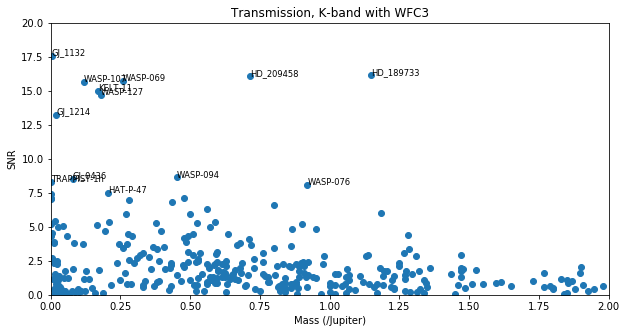

In [109]:
scale_N = 70e-6
scale_ind = list(od['System']).index('GJ_1214')
scale_mag = od['Kmag'][scale_ind]

# Magnitude ~10**deltaK/2.5, take sqrt to get noise (**0.5)
od['TSNR_K'] =  (10**(-(od['Kmag']-scale_mag)/2.5/2.))*od['ATMDEPTH'] / scale_N


Ms, SNRs, ds, names, Hmags, Gs, Teqs, Ps = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t, per 
                            in zip(od['M_b'], od['TSNR_K'], od['ATMDEPTH'], od['System'], 
                            od['Kmag'], od['g'], od['TEQ'], od['Period']) if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', xlim=[0.,2], fontsize = 'small', show=False,
           names=names, tymin=7.5, ylim=[0,20], title='Transmission, K-band with WFC3')
p.savefig('./transit/transit_snr_K.png')
p.show()

if True:
    table_arrays(['Name','Hmag','AtmDepth (ppm)','SNR', 'Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(h) for h in Hmags], [int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs], ['{:.2f}'.format(per) for per in Ps],
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs],
            ['{:.0f}'.format(t) for t in Teqs]], 
             savefile='./transit/transit_snr_K.txt', sort='SNR', reverse=True)
    
plot_html(od, xname='M_b', yname='TSNR_K', x_range=(-0.1,3), y_range=(0,20), 
          title='Transmission, K-band with WFC3', 
          fname='./transit/transit_snr_K.html')

## V band scaling (HST/STIS)

Scale precision to HD209458 b observations by Charbonneau et al (2002) of NaI line.

Photon noise limited, to about 30 ppm over 3 transits -> 52 ppm per transit.

This is then the SNR of the NaI lines for instance, not the white-light curve.

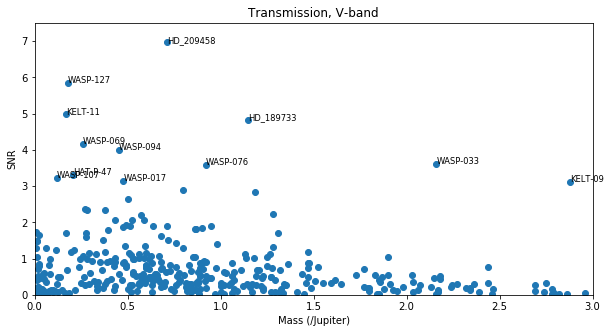

In [110]:
scale_N = 52e-6
scale_ind = list(od['System']).index('HD_209458')
scale_Vmag = od['Vmag'][scale_ind]
od['TSNR_V'] =  (10**(-(od['Vmag']-scale_Vmag)/2.5/2.))*od['ATMDEPTH'] / scale_N

Ms, SNRs, ds, names, Vmags, Gs, Teqs, Ps = zip(*[ (m, snr, d, ni, v, g, t, per) 
                                               for m, snr, d, ni, v, g, t, per in 
                                zip(od['M_b'], od['TSNR_V'], od['ATMDEPTH'], 
                                    od['System'], od['Vmag'], od['g'], od['TEQ'], od['Period'])
                                  if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', xlim=[0.,3], fontsize = 'small', show=False,
           names=names, tymin=3., ylim=[0,7.5], title='Transmission, V-band')

p.savefig('./transit/transit_snr_V.png')
p.show()

if True:
    table_arrays(['Name','Vmag','AtmDepth (ppm)','SNR', 'Period', 'Mass', 'logg', 'Eq Temp'], 
             [names,[ '{:.2f}'.format(v) for v in Vmags],
            [int(d) for d in np.array(ds)*1e6], [float('{:.1f}'.format(snr)) for snr in SNRs], 
            ['{:.2f}'.format(per) for per in Ps], [ '{:.2f}'.format(m) for m in Ms], 
            ['{:.2f}'.format(np.log(g)) for g in Gs], ['{:.0f}'.format(t) for t in Teqs]],
             savefile='./transit/transit_snr_V.txt', sort='SNR', reverse=True)
    
plot_html(od, xname='M_b', yname='TSNR_V', x_range=(-0.1,3), y_range=(0,8), 
          title='Transmission, V-band with WFC3', 
          fname='./transit/transit_snr_V.html')

# Secondary Eclipse

## Eclipsed depths for emission and reflection in V & H

In [111]:
od = get_tepcat_planets()

od['g'] = calc_surface_g(od['M_b']*Mjup, od['R_b']*Rjup)
od['TEQ'] = calc_eq_temp(od['a(AU)']*au, od['Teff'], od['R_A']*Rsun, A=0)

band = 'K'
od['EDE_K'] = eclipse_depth(od['TEQ'], od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, band=band)
od['EDR_K'] = reflected_depth(od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, od['a(AU)']*au, band=band, A=1)

band = 'V'
od['EDE_V'] = eclipse_depth(od['TEQ'], od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, band=band)
od['EDR_V'] = reflected_depth(od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun,  od['a(AU)']*au, band=band, A=1)

## H band scaling (WFC3/G141)

Scaling noise to eclipse obervations of GJ1214 b precision of 70 ppm for one visit.
Transit duration not taken into account.

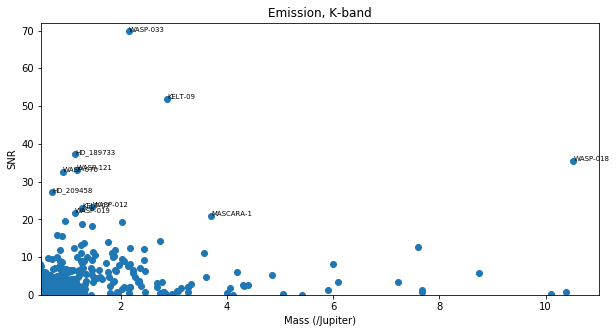

In [112]:
scale_N = 70e-6
scale_ind = list(od['System']).index('GJ_1214')
scale_mag = od['Kmag'][scale_ind]
od['EESNR_K'] =  (10**(-(od['Kmag']-scale_mag)/2.5/2.))*od['EDE_K'] / scale_N

Ms, SNRs, ds, names, Hmags, Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t, per 
                            in zip(od['M_b'], od['EESNR_K'], od['EDE_K'], 
                            od['System'], od['Kmag'], od['g'], od['TEQ'], od['Period'])
                        if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Emission, K-band', 
            names=names, tymin=20, xlim=[0.5,11], ylim=[0,72])
p.savefig('./emission/emission_snr_K.png')
p.show()

if True:
    table_arrays(['Name','Hmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
             [names,[ '{:.2f}'.format(h) for h in Hmags],[int(d) for d in np.array(ds)*1e6],
             [float('{:.1f}'.format(snr)) for snr in SNRs], ['{:.2f}'.format(per) for per in Ps], 
             [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
             ['{:.0f}'.format(t) for t in Teqs]],
             savefile='./emission/emission_snr_K.txt', sort='SNR', reverse=True)
    
plot_html(od, xname='M_b', yname='EESNR_K', x_range=(-0.1,11), y_range=(0,72), 
          title='Emission, K-band with WFC3', 
          fname='./emission/emission_snr_K.html')

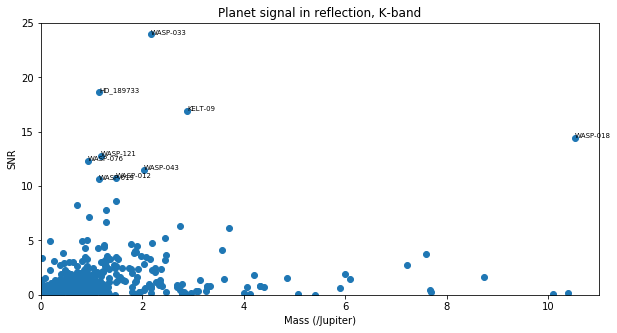

In [118]:
scale_N = 70e-6
scale_ind = list(od['System']).index('GJ_1214')
scale_mag = od['Kmag'][scale_ind]
od['ERSNR_K'] =  (10**(-(od['Kmag']-scale_mag)/2.5/2.))*od['EDR_K'] / scale_N

Ms, SNRs, ds, names, Hmags, Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t ,per 
                            in zip(od['M_b'], od['ERSNR_K'], od['EDR_K'], 
                            od['System'], od['Kmag'],od['g'], od['TEQ'], od['Period'])
                            if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in reflection, K-band', 
            names=names, tymin=10, xlim=[0.,11], ylim=[0,25])
p.savefig('./reflection/reflection_snr_K.png')
p.show()

if True:
    table_arrays(['Name','Hmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(h) for h in Hmags],[int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs],['{:.2f}'.format(per) for per in Ps], 
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
            ['{:.0f}'.format(t) for t in Teqs]], 
            savefile='./reflection/reflection_snr_K.txt', sort='SNR', reverse=True)
    
plot_html(od, xname='M_b', yname='ERSNR_K', x_range=(-0.1,11), y_range=(0,25), 
          title='Reflection, K-band with WFC3', 
          fname='./reflection/reflecion_snr_K.html')

In [63]:
trappists = [ get_planet(name, od) for name in od['System'] if name.startswith('TRAPPIST')]
print [trap['System'] for trap in trappists]

print trappists[-1]

['TRAPPIST-1b', 'TRAPPIST-1c', 'TRAPPIST-1d', 'TRAPPIST-1e', 'TRAPPIST-1f', 'TRAPPIST-1g', 'TRAPPIST-1h']
{'EDR_V': 2.7541481985322355e-07, 'M_b': 0.0003, 'System': 'TRAPPIST-1h', 'EDR_K': 2.7541481985322355e-07, 'g_b': -1.0, 'EESNR_K': 2.054471449353114e-12, 'ERSNR_K': 0.0019538412107534043, 'Vmag': 18.8, 'M_A': 0.089, 'Kmag': 10.3, 'Teq': 169.2, 'a(AU)': 0.0617, 'TEQ': 201.68710861652258, 'loggA': -1.0, 'Discovery_reference': '2017NatAs...1E.129L', 'rho_b': -1.0, 'EDE_V': 5.3771770247398535e-49, 'EDE_K': 2.8959972847486066e-16, 'rho_A': 51.1, 'R_b': 0.0693, 'Recent_reference': 'arXiv:1801.02554', 'e': 0.0, 'Teff': 2511.0, 'g': 1.6202419369032597, 'Period': 18.768, '[Fe/H]': 0.04, 'R_A': 0.121}


## V band scaling (HST/STIS)

Scale precision to HD209458 b white-light curve by Brown et al (2001).

About 110 ppm per transit.

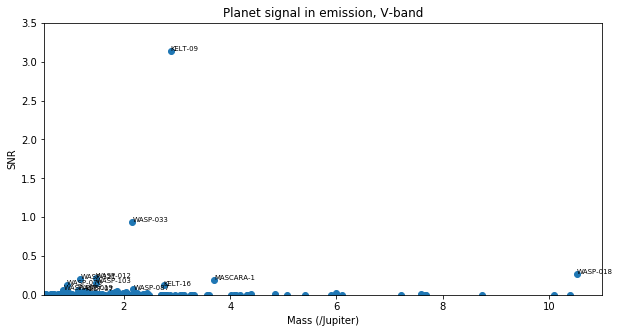

In [123]:
scale_N = 110e-6
scale_ind = list(od['System']).index('HD_209458')
scale_Vmag = od['Vmag'][scale_ind]
od['EESNR_V'] =  (10**(-(od['Vmag']-scale_Vmag)/2.5/2.))*od['EDE_V'] / scale_N

Ms, SNRs, ds, names, Vmags,  Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                 for m, snr, d, ni, h, g, t ,per 
                            in zip(od['M_b'], od['EESNR_V'], od['EDE_V'], 
                            od['System'], od['Vmag'],od['g'], od['TEQ'], od['Period'])
                        if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in emission, V-band', 
            names=names, tymin=0.05, xlim=[0.5,11], ylim=[0,3.5])
p.savefig('./emission/emission_snr_V.png')
p.show()

if True:
    table_arrays(['Name','Vmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(v) for v in Vmags], [int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs],['{:.2f}'.format(per) for per in Ps], 
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
            ['{:.0f}'.format(t) for t in Teqs]], 
            savefile='./emission/emission_snr_V.txt', sort='SNR', reverse=True)
    
plot_html(od, xname='M_b', yname='EESNR_V', x_range=(-0.1,11), y_range=(0,3.5), 
          title='Emission, V-band with WFC3', 
          fname='./emission/emission_snr_V.html')

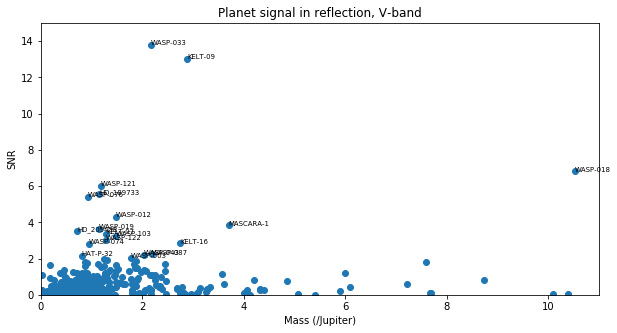

In [126]:
scale_N = 110e-6
scale_ind = list(od['System']).index('WASP-018')
scale_Vmag = od['Vmag'][scale_ind]
od['ERSNR_V'] =  (10**(-(od['Vmag']-scale_Vmag)/2.5/2.))*od['EDR_V'] / scale_N

Ms, SNRs, ds, names, Vmags, Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t, per 
                            in zip(od['M_b'], od['ERSNR_V'], od['EDR_V'], 
                            od['System'], od['Vmag'],od['g'], od['TEQ'], od['Period'])
                        if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in reflection, V-band', 
            names=names, tymin=2, xlim=[0.,11], ylim=[0,15])
p.savefig('./reflection/reflection_snr_V.png')
p.show()

if True:
    table_arrays(['Name','Vmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(v) for v in Vmags], [int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs], ['{:.2f}'.format(per) for per in Ps], 
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
            ['{:.0f}'.format(t) for t in Teqs]], 
            savefile='./reflection/reflection_snr_V.txt', sort='SNR', reverse=True)
    
plot_html(od, xname='M_b', yname='ERSNR_V', x_range=(-0.1,11), y_range=(0,15), 
          title='Reflection, V-band with WFC3', 
          fname='./reflection/reflection_snr_K.html')

# 

# MIRI LRS in Eclipses in Emission

Scale to some late G / early K star (<5000K or so)

Simulate with Pandexo and the scale noise accordingly

use the Rayleigh-Jeans approximation to get magnitudes at 5 and 10 micron

###  Secondary eclipses, only in emission, no albedo, in K-band

In [44]:
od = get_tepcat_planets()

od['g'] = calc_surface_g(od['M_b']*Mjup, od['R_b']*Rjup)
od['TEQ'] = calc_eq_temp(od['a(AU)']*au, od['Teff'], od['R_A']*Rsun, A=0)
od['EDE_5mu'] = eclipse_depth(od['TEQ'], od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, band=(5e-6,8e-6))*1e6
od['EDE_10mu'] = eclipse_depth(od['TEQ'], od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, band=(8e-6,11e-6))*1e6

print get_planet('HD_189733', od)

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


{'EDE_5mu': 3240.0460917351515, 'System': 'HD_189733', 'g_b': 21.5, 'EDE_10mu': 4241.861104568934, 'Vmag': 7.68, 'M_A': 0.84, 'Kmag': 5.54, 'a(AU)': 0.03142, 'M_b': 1.15, 'TEQ': 1417.0283273967677, 'loggA': 4.61, 'Discovery_reference': '2005A+A...444L..15B', 'rho_b': 0.75, 'Teq': 1191.0, 'rho_A': 1.98, 'R_b': 1.151, 'Recent_reference': '2010MNRAS.408.1689S', 'e': 0.0041, 'Teff': 5050.0, 'g': 22.51501685785844, 'Period': 2.219, '[Fe/H]': -0.03, 'R_A': 0.752}


### Calculate noise, scaled to one simulation with Pandexo

Rayleigh-Jeans law:

BB(T) = T / lambda**4

So can use this to scale the noise between stars, since the flux therefore scales like T and the noise like sqrt(T)

Okay but also need magnitude in there somewhere, what can we do with Kmags

Need to compare to Vega to get proper scaling between K and 5-10 micron

In [45]:
# For K78, eclipse depth is 
K78_Teq = calc_eq_temp(0.01*au, 5089, 0.74*Rsun, A=0)
K78_EDE_5mu = eclipse_depth(K78_Teq, 5089, 0.107057*Rjup, 0.74*Rsun, band=(4.5e-6,5.5e-6))*1e6
print 'Eclipse depth at 5 micron for K78b is {:.0f} ppm'.format(K78_EDE_5mu)

print 'Rayleigh-Jeans approx. depth = {:.0f}'.format((2500/5000.)**0.5*(0.01)**2*1e6)

Eclipse depth at 5 micron for K78b is 74 ppm
Rayleigh-Jeans approx. depth = 71


In [46]:
K78 = get_planet('Kepler-078', od)

scale_N_5mu = 38e-6 # noise with MIRI LRS in Pandexo for K-78 between 5-8 micron
scale_N_10mu = 92e-6 # noise between 8-10 micron
scale_Ts = K78['Teff']
scale_Rs = K78['R_A'] # Rsun
scale_mag = K78['Kmag'] # magnitude of K78 in K band

scale_Fs_K = bb_flux(scale_Ts, R=scale_Rs*Rsun, band='K')
scale_Fs_5mu = bb_flux(scale_Ts, R=scale_Rs*Rsun, band=(5e-6,8e-6))
scale_Fs_10mu = bb_flux(scale_Ts, R=scale_Rs*Rsun, band=(8e-6,11e-6))

# Just integrate all the bbs in K band and between 5-8 and 8-10 micron
bb_K = np.array([ bb_flux(Ts,Rs*cs.Rsun, band='K') for Ts, Rs in zip(od['Teff'], od['R_A'])])
bb_5mu = np.array([ bb_flux(Ts,Rs*cs.Rsun, band=(5e-6,8e-6)) for Ts, Rs in zip(od['Teff'], od['R_A'])])
bb_10mu = np.array([ bb_flux(Ts,Rs*cs.Rsun, band=(8e-6,11e-6)) for Ts, Rs in zip(od['Teff'], od['R_A'])])



#                  Eclipse depth  Pandexo noise              Kmag scaling               
od['EESNR_5mu'] = od['EDE_5mu']*1e-6 / scale_N_5mu  *(10**(-(od['Kmag']-scale_mag)/2.5/2.))\
                    *((bb_5mu/bb_K)/(scale_Fs_5mu/scale_Fs_K))**0.5 
# Rescale from K-band to 5mu, don't need this since in R-J?
od['EESNR_10mu'] = od['EDE_10mu']*1e-6 / scale_N_10mu  *(10**(-(od['Kmag']-scale_mag)/2.5/2.))\
                    *((bb_10mu/bb_K)/(scale_Fs_10mu/scale_Fs_K))**0.5

In [47]:
print map(lambda x: get_planet('HD_189733', od)[x], ['System', 'EDE_5mu', 'EDE_10mu', 'EESNR_5mu', 'EESNR_10mu'])
print map(lambda x: get_planet('GJ_1214', od)[x], ['System', 'EDE_5mu', 'EDE_10mu', 'EESNR_5mu', 'EESNR_10mu'])
print map(lambda x: get_planet('Kepler-078', od)[x], ['System', 'EDE_5mu', 'EDE_10mu', 'EESNR_5mu', 'EESNR_10mu'])

['HD_189733', 3240.0460917351515, 4241.861104568934, 552.6055432177853, 299.01813659953615]
['GJ_1214', 523.9980096389435, 1043.9417294597968, 24.442892306094397, 20.788730149229934]
['Kepler-078', 86.86948340348707, 94.84840775159292, 2.28603903693387, 1.0309609538216622]


In [68]:
# ['Name','Kmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp']


csv_arrays('./emission/emission_snr_5mu.csv', od, 
           keys=['System', 'EESNR_5mu', 'EDE_5mu', 'Kmag', 'TEQ', 'Period', 'M_b'],
           names=['System', 'SNR', 'Eclipse Depth', 'Kmag', 'Teq', 'Period', 'Planet Mass'],
           units = ['-', '-', 'ppm', '-', 'K', 'd', 'Mjup'],
           formats=['{}','{:.1f}','{:.0f}','{:.2f}','{:.1f}','{:.2f}','{:.2f}'],
           sort='EESNR_5mu', reverse=True)

csv_arrays('./emission/emission_snr_10mu.csv', od, 
           keys=['System', 'EESNR_10mu', 'EDE_10mu', 'Kmag', 'TEQ', 'Period', 'M_b'],
           names=['System', 'SNR', 'Eclipse Depth', 'Kmag', 'Teq', 'Period', 'Planet Mass'],
           units = ['-', '-', 'ppm', '-', 'K', 'd', 'Mjup'],
           formats=['{}','{:.1f}','{:.0f}','{:.2f}','{:.1f}','{:.2f}','{:.2f}'],
           sort='EESNR_10mu', reverse=True)

plot_html(od, xname='M_b', yname='EESNR_5mu', x_range=(-0.1,11), y_range=(0,350), 
          title='Emission, 5-8 micron, scaled to Kepler-78 with MIRI/LRS', 
         fname='./emission/emission_snr_5mu.html')

plot_html(od, xname='M_b', yname='EESNR_10mu', x_range=(-0.1,11), y_range=(0,600), 
          title='Emission, 8-10 micron, scaled to Kepler-78 with MIRI/LRS', 
         fname='./emission/emission_snr_10mu.html')

[(nan, <type 'numpy.float64'>), ('Kepler-223d', <type 'numpy.string_'>), (nan, <type 'numpy.float64'>), (-1.0, <type 'numpy.float64'>), (nan, <type 'numpy.float64'>), (15.54, <type 'numpy.float64'>), (1.125, <type 'numpy.float64'>), (13.63, <type 'numpy.float64'>), (-1.0, <type 'numpy.float64'>), (nan, <type 'numpy.float64'>), (nan, <type 'numpy.float64'>), (4.07, <type 'numpy.float64'>), ('2014ApJ...784...45R', <type 'numpy.string_'>), (0.23, <type 'numpy.float64'>), (-1.0, <type 'numpy.float64'>), (0.0252, <type 'numpy.float64'>), (-1.0, <type 'numpy.float64'>), (0.467, <type 'numpy.float64'>), ('2016Natur.533..509M', <type 'numpy.string_'>), (0.037, <type 'numpy.float64'>), (5821.0, <type 'numpy.float64'>), (2.9970353331113304, <type 'numpy.float64'>), (14.789, <type 'numpy.float64'>), (-0.06, <type 'numpy.float64'>), (1.72, <type 'numpy.float64'>)]


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# No B band magnitudes from TEPCat

So this code will not run.

## B band scaling (HST/STIS)

Scale precision to HD189733 b albedo measurements by Evans et al.

290 - 450 nm : Ag = 0.40 (0.12)
450 - 570 nm : Ag = 0.00 (0.12)

# Emission/Reflection

Calculate emitted/reflected flux in B, V, I, Z, H and K bands and quote the peak wavelength of the star and planet in each case. Use central wavelengths rather than integrating.

Make tables sorting by V, H and BB peak for planet.

In [77]:
print 0.25*cs.Rjup
print 2.678*cs.Rearth

17477750.0
17061538.0


In [75]:
print get_planet('GJ_1214',od)

{'EDE_5mu': 523.9980096389435, 'System': 'GJ_1214', 'EESNR_5mu': 24.442892306094397, 'g_b': 7.6, 'EDE_10mu': 1043.9417294597968, 'Vmag': 14.67, 'M_A': 0.15, 'Kmag': 8.78, 'a(AU)': 0.01411, 'EESNR_10mu': 20.788730149229934, 'TEQ': 679.0685488258935, 'loggA': 4.944, 'Discovery_reference': '2009Natur.462..891C', 'rho_b': 1.12, 'Teq': 547.0, 'M_b': 0.0197, 'rho_A': 16.54, 'R_b': 0.254, 'Recent_reference': '2013A+A...549A..10H', 'e': 0.0, 'Teff': 3026.0, 'g': 7.919976196153055, 'Period': 1.58, '[Fe/H]': 0.39, 'R_A': 0.216}


In [210]:
# Using SNR*f metric
# K is not the right bandpass, use H, so need to get H-mags
for A in [0.1, 0.5, 1.0]:

    od = get_tepcat_planets()

    od['TEQ'] = calc_eq_temp(od['a(AU)']*au, od['Teff'], od['R_A']*Rsun, A=A)

    od['PPEAK_L'] = weins_peak(od['TEQ'])
    od['SPEAK_L'] = weins_peak(od['Teff'])

    central_l = {'V':551e-9, 'K':2.19e-6} #{'B':445e-9, 'V':551e-9, 'I':806e-9, 'Z':900e-6, 'H':1.63e-6, 'K':2.19e-6}

    scale_N_K = 70e-6 / (.76/.58)**0.5 # accounting for duty cycle change for bi-direction scan
    scale_ind_K = list(od['System']).index('GJ_1214')
    scale_Kmag = od['Kmag'][scale_ind_K]
    scale_N_V = 52e-6
    scale_ind_V = list(od['System']).index('HD_209458')
    scale_Vmag = od['Vmag'][scale_ind_V]

    # calculate ratios
    od['EDE_V'] = eclipse_depth(od['TEQ'], od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, band='V')*1e6 # in ppm
    od['EDR_V'] = reflected_depth_quick(od['R_b']*Rjup, od['a(AU)']*au, A=A)*1e6
    od['R_frac_V'] = od['EDR_V'] / (od['EDE_V']+od['EDR_V'])*100
    od['SNR_V'] =  (10**(-(od['Vmag']-scale_Vmag)/2.5/2.))*(od['EDE_V']+od['EDR_V'])*1e-6 / scale_N_V
    od['M_V'] = od['R_frac_V'] * od['SNR_V'] / od['TEQ']

    od['EDE_K'] = eclipse_depth(od['TEQ'], od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, band='K')*1e6
    od['EDR_K'] = od['EDR_V']
    od['SNR_K'] =  (10**(-(od['Kmag']-scale_Kmag)/2.5/2.))*(od['EDE_K']+od['EDR_K'])*1e-6 / scale_N_K
    od['R_frac_K'] = od['EDR_K'] / (od['EDE_K']+od['EDR_K'])*100
    od['M_K'] = od['R_frac_K'] * od['SNR_K'] / od['TEQ']

    allowed = np.isfinite(od['R_frac_V']) 
    for band in ['V', 'K']:

        csv_arrays('./reflection_metric_tables/reflection_fraction_{}_{}.csv'.format(band,A), od, 
               keys=['System', 'M_'+band, 'R_frac_'+band, 'SNR_'+band, 'EDE_'+band, 'EDR_'+band, 'TEQ', 'SPEAK_L', band+'mag'],
               names=['System', 'Metric', 'Reflected Fraction', 'SNR', 'Eclipse Depth (emitted)', 'Eclipse Depth (reflected)', 
                      'Teq', 'Peak wavelength (star)', band+'mag'],
               units = ['-','f*SNR/Teq','%','-', 'ppm','ppm', 'K', 'micron', '-'],
               formats = ['{}','{:.4f}','{:.1f}','{:.1f}','{:.0f}','{:.0f}','{:.0f}','{:.3f}','{:.2f}'],
               sort='M_'+band, reverse=True)

        y2 = 1.1*max([ od['M_'+band][i] for i in range(len(od['System'])) if not od['System'][i].startswith('OGLE')])
        plot_html(od, xname='M_b', yname='M_'+band, x_range=(-0.1,11), y_range=(0,y2), 
              title='Reflection, {}-band metric (reflected_fraction*SNR/Teq)'.format(band), 
              fname='./reflection_metric_tables/reflection_fraction_{}_{}.html'.format(band,A))

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in divide


## Check G141 vs G102 for WASP-80b

Just use J-band, scale G141 to GJ1214, G102 to WASP-12

In [15]:
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','H','K','J', 'PER', 'V'])

A = 0.7

W80 = get_planet('WASP-80 b', od)
ind = list(od['NAME']).index('WASP-80 b')
print W80
print

scale_J_G141 = 70e-6 / (.76/.58)**0.5  / np.sqrt(20) # accounting for duty cycle change for bi-direction scan
GJ1214 = get_planet('GJ 1214 b', od)
scale_Jmag_G141 = GJ1214['J']

scale_J_G102 = 164e-6  /1.34*1.1 / np.sqrt(30) # 34% above photon noise -> 20%
print scale_J_G102*1e6
WASP12 = get_planet('WASP-12 b', od)
scale_Jmag_G102= WASP12['J']

W80['TEQ'] = calc_eq_temp(W80['A']*au, W80['TEFF'], W80['RSTAR']*Rsun, A=A)
W80['g'] = calc_surface_g(W80['MASS']*Mjup, W80['R']*Rjup)

band = 'G141'
ede_141 = eclipse_depth(W80['TEQ'], W80['TEFF'], W80['R']*Rjup, W80['RSTAR']*Rsun, band=band)
edr_141 = reflected_depth(W80['TEFF'], W80['R']*Rjup, W80['RSTAR']*Rsun,  W80['A']*au, band=band, A=A)
snr_141 = (10**(-(W80['J']-scale_Jmag_G141)/2.5/2.))*(ede_141+edr_141) / scale_J_G141

band = 'G102'
ede_102 = eclipse_depth(W80['TEQ'], W80['TEFF'], W80['R']*Rjup, W80['RSTAR']*Rsun, band=band)
edr_102 = reflected_depth(W80['TEFF'], W80['R']*Rjup, W80['RSTAR']*Rsun,  W80['A']*au, band=band, A=A)
snr_102 = (10**(-(W80['J']-scale_Jmag_G102)/2.5/2.))*(ede_102+edr_102) / scale_J_G102

print 'G102: Depth {:.1f}, SNR {:.2f}'.format((ede_102+edr_102)*1e6, snr_102)
print 'G141: Depth {:.1f}, SNR {:.2f}'.format((ede_141+edr_141)*1e6, snr_141)

{'A': 0.034469600000000003, 'NAME': 'WASP-80 b', 'RSTAR': 0.57099999999999995, 'H': 8.5129999999999999, 'K': 110.90000000000001, 'J': 9.218, 'PER': 3.0678504000000002, 'R': 0.95199999999999996, 'MASS': 0.551763, 'V': 11.699999999999999, 'TEFF': 4145.0}

24.5793903915
G102: Depth 116.6, SNR 8.47
G141: Depth 116.8, SNR 10.91


In [16]:
print snr_102 / snr_141

0.775956380539


In [17]:
print W80
print GJ1214
print WASP12

{'A': 0.034469600000000003, 'NAME': 'WASP-80 b', 'g': 15.79078647185167, 'RSTAR': 0.57099999999999995, 'H': 8.5129999999999999, 'K': 110.90000000000001, 'J': 9.218, 'PER': 3.0678504000000002, 'R': 0.95199999999999996, 'MASS': 0.551763, 'V': 11.699999999999999, 'TEQ': 716.12049792906726, 'TEFF': 4145.0}
{'A': 0.014325299999999999, 'NAME': 'GJ 1214 b', 'RSTAR': 0.21099999999999999, 'H': 9.0939999999999994, 'K': 12.199999999999999, 'J': 9.75, 'PER': 1.58040482, 'R': 0.2389, 'MASS': 0.020350699999999999, 'V': 15.1, 'TEFF': 3026.0}
{'A': 0.022532900000000002, 'NAME': 'WASP-12 b', 'RSTAR': 1.6299999999999999, 'H': 10.228, 'K': 226.0, 'J': 10.477, 'PER': 1.09142245, 'R': 1.79, 'MASS': 1.36063, 'V': 11.69, 'TEFF': 6300.0}


In [46]:
with open('/home/jacob/Exo_Data/W80_sym/tholin/etc_friendly.alb', 'r') as g:
    lines = g.readlines()
lines = [ line[:-1].split() for line in lines]
w, f = zip(*[ [float(val) for val in line] for line in lines])
w = np.array(w)*1e-6
lines = [ '{}\t{}\n'.format(wi, fi) for wi, fi in zip(w,f) ]

with open('/home/jacob/Exo_Data/W80_sym/tholin/etc_friendly.alb', 'w') as g:
    for line in lines:
        g.write(line)

## Eclipse depths for HAT-P-2b

In [13]:
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','H','K','J', 'PER', 'V'])
A = 0.

P = get_planet('HAT-P-2 b', od)
print P['A']
P['TEQ'] = calc_eq_temp(P['A']*au, P['TEFF'], P['RSTAR']*Rsun, A=A)
P['g'] = calc_surface_g(P['MASS']*Mjup, P['R']*Rjup)
print P['TEQ']
P['TEQ'] = 2200
print P

spitzer = eclipse_depth(P['TEQ'], P['TEFF'],P['R']*Rjup, P['RSTAR']*Rsun, band='Spitzer1')
hst = eclipse_depth(P['TEQ'], P['TEFF'],P['R']*Rjup, P['RSTAR']*Rsun, band='G141')

print spitzer*1e6
print hst*1e6

0.0679088
1698.95324536
{'A': 0.067908800000000005, 'NAME': 'HAT-P-2 b', 'g': 171.8754346914661, 'RSTAR': 1.506, 'H': 7.6520000000000001, 'K': 983.89999999999998, 'J': 7.7960000000000003, 'PER': 5.6334729000000001, 'R': 1.157, 'MASS': 8.8706499999999995, 'V': 8.7100000000000009, 'TEQ': 2200, 'TEFF': 6290.0}
1002.28158693
199.622185808


In [14]:

print calc_eq_temp((0.0674 - 0.00081)*au*(1-0.5171-0.0033), P['TEFF'], P['RSTAR']*Rsun, A=0.)
print calc_eq_temp((0.0674 + 0.00081)*au*(1-0.5171+0.0033), P['TEFF'], P['RSTAR']*Rsun, A=0.)
#0.0674 0.00081
#0.5171 0.0033

print calc_eq_temp((0.0674 - 0.00081)*au*(1+0.5171-0.0033), P['TEFF'], P['RSTAR']*Rsun, A=0.)
print calc_eq_temp((0.0674 + 0.00081)*au*(1+0.5171+0.0033), P['TEFF'], P['RSTAR']*Rsun, A=0.)

2477.42411605
2431.15670741
1394.45883297
1374.80625778


In [16]:
print get_planet('WASP-18 b', od)

{'A': 0.020140100000000001, 'NAME': 'WASP-18 b', 'RSTAR': 1.216, 'H': 8.2309999999999999, 'K': 1818.3, 'J': 8.4090000000000007, 'PER': 0.94145290000000004, 'R': 1.2669999999999999, 'MASS': 10.2006, 'V': 9.3926999999999996, 'TEFF': 6400.0}


# Scaling phase-curves for trappist planets with JWST

In [46]:
trappist_a = np.array([0.011, 0.015, 0.021, 0.028, 0.037, 0.045, 0.06])
trappist_rp = np.array([1.09, 1.06, 0.77, 0.92, 1.04, 1.13, 0.76])
refl = (trappist_rp/trappist_a*6.7e6/au)**2 

trappist_Teq = calc_eq_temp(trappist_a*au, 2500, 0.114*Rsun, A=0)

print refl*1e6

emit = np.array([ eclipse_depth(T, 2550., rp*6.7e6, 0.114*Rsun, 'K') for T, rp in zip(trappist_Teq, trappist_rp) ])

print emit*1e6

[ 19.69491197  10.01649159   2.69667916   2.16543928   1.58470945
   1.26478958   0.32181857]
[  5.96944554e-02   5.15090721e-03   1.29425231e-04   8.90835637e-06
   3.90043563e-07   3.22269803e-08   1.78985392e-10]


# LP 358-348, 3 small planets predictions

System parameters

In [90]:
LP = {'V':11.52, 'H':8.496, 'RSTAR':0.723, 'TEFF':4359.}
LPb = {'NAME':'LP 358-348 b', 'PER':7.9757, 'R':1.05, 'A/RSTAR':22.2, 'MASS':1.5}
LPc = {'NAME':'LP 358-348 c', 'PER':17.30681, 'R':3.14, 'A/RSTAR':39.4, 'MASS':11.6}
LPd = {'NAME':'LP 358-348 d', 'PER':25.5715, 'R':1.55, 'A/RSTAR':48.3, 'MASS':4.6}

mu = 1.2 # mean molecular weight, hydrogen rich!

In [91]:
for LPi in [LPb, LPc, LPd]:
    LPi['A'] = LPi['A/RSTAR'] * (LP['RSTAR'] * Rsun) / au
    LPi['TEQ'] = calc_eq_temp(LPi['A']*au, LP['TEFF'], LP['RSTAR']*Rsun)
    LPi['g'] = calc_surface_g(LPi['MASS']*Mearth, LPi['R']*Rearth)
    
    LPi['SH'] = calc_scale_h(LPi['TEQ'], LPi['g'], mu=mu)
    LPi['SH_wet'] = calc_scale_h(LPi['TEQ'], LPi['g'], mu=18.)
    
    LPi['ATMDEPTH'] = calc_transit_depth(LPi['SH'], LPi['R']*Rearth, LP['RSTAR']*Rsun)
    LPi['ATMDEPTH_wet'] = calc_transit_depth(LPi['SH_wet'], LPi['R']*Rearth, LP['RSTAR']*Rsun)

Scale noise to GJ1214 observations, 70 ppm for one visit, ignore transit duration

In [96]:
# First need atm depth of GJ1214b
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()

od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','H', 'PER'])
od['TEQ'] = calc_eq_temp(od['A']*au, od['TEFF'], od['RSTAR']*Rsun)
od['g'] = calc_surface_g(od['MASS']*Mjup, od['R']*Rjup)
od['SH'] = calc_scale_h(od['TEQ'], od['g'])
od['ATMDEPTH'] = calc_transit_depth(od['SH'], od['R']*Rjup, od['RSTAR']*Rsun)

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


In [115]:
# Then scale for these planets, one transit
scale_N = 70e-6
scale_ind = list(od['NAME']).index('GJ 1214 b')
scale_Hmag = od['H'][scale_ind]
for LPi in [LPb, LPc, LPd]:
    LPi['TSNR_H'] =  (10**(-(LP['H']-scale_Hmag)/2.5/2.))*LPi['ATMDEPTH'] / scale_N
    LPi['TSNR_H_wet'] =  (10**(-(LP['H']-scale_Hmag)/2.5/2.))*LPi['ATMDEPTH_wet'] / scale_N

In [120]:
print 'For H2 dominated atmospheres'
print
print 'Name\tScaleH\tAtm d\tTeq\tg\tSNR'
print '-\tkm\tppm\tK\tm/s^2'
for LPi in [LPb, LPc, LPd]:
    print '{}\t{:.0f}\t{:.1f}\t{:.0f}\t{:.1f}\t{:.2f}'.format(LPi['NAME'].split()[-1], \
                                        LPi['SH']/1e3,LPi['ATMDEPTH']*1e6,LPi['TEQ'],LPi['g'], LPi['TSNR_H'])
    
print
print 'For water dominated atmospheres'
print
print 'Name\tScaleH\tAtm d\tTeq\tg\tSNR'
print '-\tkm\tppm\tK\tm/s^2'
for LPi in [LPb, LPc, LPd]:
    print '{}\t{:.0f}\t{:.1f}\t{:.0f}\t{:.1f}\t{:.2f}'.format(LPi['NAME'].split()[-1], \
                                        LPi['SH_wet']/1e3,LPi['ATMDEPTH_wet']*1e6,LPi['TEQ'],LPi['g'],LPi['TSNR_H_wet'])

For H2 dominated atmospheres

Name	ScaleH	Atm d	Teq	g	SNR
-	km	ppm	K	m/s^2
b	401	21.2	778	13.4	0.40
c	348	55.0	584	11.5	1.03
d	193	15.1	527	18.8	0.28

For water dominated atmospheres

Name	ScaleH	Atm d	Teq	g	SNR
-	km	ppm	K	m/s^2
b	27	1.4	778	13.4	0.03
c	23	3.7	584	11.5	0.07
d	13	1.0	527	18.8	0.02


## JM talk plot

In [13]:
def add_planet(planet, od):
    for var in od:
        od[var] = np.hstack([od[var],planet[var]])

In [14]:
import constants as cs
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()

od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','MSTAR', 'PER'])

M1b = {'NAME':'MASCARA-1 b','R':1.5,'MASS':3.7,'A':0.043,'TEFF':7554, 'RSTAR':2.1,'PER':2.14878, 'MSTAR':1.72}
M2b = {'NAME':'MASCARA-2 b','R':2.2,'MASS':15.,'A':0.067,'TEFF':8981,'RSTAR':1.9,'PER':3.4741, 'MSTAR':2.0}
K9b = {'NAME':'KELT-9 b','R':1.891,'MASS':2.88,'A':0.03462,'TEFF':7430,'RSTAR':2.362,'PER':1.48, 'MSTAR':2.52}
K11b = {'NAME':'KELT-11 b','R':1.37,'MASS':0.195,'A':0.06229,'TEFF':5370,'RSTAR':2.72,'PER':4.737, 'MSTAR':1.438}
K13b = {'NAME':'KELT-13 b','R':1.58,'MASS':8.,'A':0.0365,'TEFF':7043,'RSTAR':1.756,'PER':2.020, 'MSTAR':1.59}
W33b = {'NAME':'WASP-33 b','R':1.603,'MASS':2.1,'A':0.02558,'TEFF':7400,'RSTAR':1.444,'PER':1.22, 'MSTAR':1.495}
for planet in [M1b, M2b, K9b, K11b, K13b, W33b]: add_planet(planet, od)
    
od['TEQ'] = calc_eq_temp(od['A']*au, od['TEFF'], od['RSTAR']*Rsun, A=0)

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


In [22]:
def add_label(ax, point, labelpoint, text, **kwargs):
    
    ax.text(labelpoint[0], labelpoint[1], text, weight='bold', \
            bbox=dict(facecolor='w', edgecolor='black', boxstyle='round,pad=0.4', alpha=1, zorder=2))
    ax.plot([labelpoint[0],point[0]], [labelpoint[1],point[1]], **kwargs)

WASP-121 b
WASP-103 b
WASP-18 b
WASP-78 b
HAT-P-7 b
WASP-12 b
MASCARA-1 b
KELT-9 b
KELT-13 b
WASP-33 b


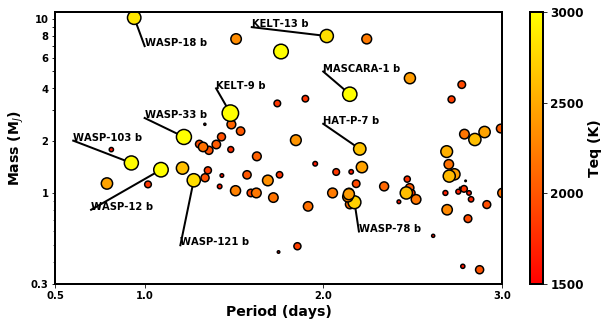

In [295]:
labeldict = {'WASP-18 b':(1.,7.), 'WASP-121 b':(1.2,0.5), 'WASP-103 b':(0.6,2), 'KELT-9 b':(1.4,4),\
             'WASP-33 b':(1.0,2.7), 'WASP-12 b': (0.7, 0.8), 'KELT-13 b':(1.6,9), \
            'MASCARA-1 b': (2.,5.), 'HAT-P-7 b': (2.,2.5), 'WASP-78 b': (2.2,0.6)}

y = 'MASS'
x = 'PER'
c = 'TEQ'

cm = p.cm.get_cmap('hot')

fig, ax = p.subplots()


sizes = (od['TEQ'] - 1500) / 1500. * 200

scax = ax.scatter(od[x], od[y], c=od[c], marker='o', 
          cmap='autumn', edgecolor='k', s=sizes, vmin=1500, vmax=3000, \
          lw = 1.5, zorder=-2)
p.xlabel('Period (days)', fontsize=14, weight='bold')
p.ylabel('Mass (M$_J$)', fontsize=14, weight='bold')

cbar = p.colorbar(scax, ticks=[1500,2000,2500,3000])
cbar.set_label(label='Teq (K)', fontsize=14, weight='bold')
cbar.ax.set_yticklabels([1500,2000,2500,3000], fontsize=12, weight='bold')
p.ylim([0.3,11.])
p.xlim([0.5,3])

ax.set_yscale("log", nonposy='clip')
ax.set_yticks([0.3,1,2,3,4,5,6,7,8,9,10])
ax.set_yticklabels([0.3,1,2,'',4,'',6,'',8,'',10], weight='bold')

ax.set_xticks([0.5,1.0,2.0,3.0])
ax.set_xticklabels([0.5,1.0,2.0,3.0], weight='bold')
p.rc('axes', linewidth=2)
ax.zorder = -10

for planet in od['NAME']:
    planet = get_planet(planet, od)
    if planet['MASS'] < .3: continue
    if planet['NAME'].startswith('KOI') or planet['NAME'].startswith('OGLE'): 
        continue
    if planet['PER'] > 2.3: continue
        
    if planet['TEQ'] > 2500.:
        #ax.text(planet[x]+.05, planet[y], planet['NAME'], \
        #      weight='bold', rotation=10, zorder=2, \
        #      bbox=dict(facecolor='w', edgecolor='black', boxstyle='round,pad=0.4', alpha=1, zorder=2))
        print planet['NAME']
        try: 
            label = labeldict[planet['NAME']]
            point = (planet[x], planet[y])
        except KeyError: 
            label = (planet[x]+0.05,planet[y])
            point = (planet[x], planet[y])
        add_label(ax, point, label, planet['NAME'], color='k', lw=2, zorder=-5)
        
#p.savefig('/home/jacob/Dropbox/plots/vhj_boxless.png', dpi=300, bbox_inches='tight')
p.show()

WASP-121 b (1.4, 1.3) WASP-103 b (0.55, 1.5) WASP-18 b (0.6, 2.4) HAT-P-7 b (2.25, 1.8) HAT-P-57 b (2.5, 2.15) Kepler-13 b (1.8, 2.2) WASP-82 b (2.8, 1.9) WASP-12 b (0.9, 2.2) WASP-100 b (3.0, 1.7) MASCARA-1 b (2.2, 2.5) MASCARA-2 b (3.0, 2.3) KELT-9 b (1.7, 2.6) KELT-13 b (2, 2) WASP-33 b (1.3, 2.0)

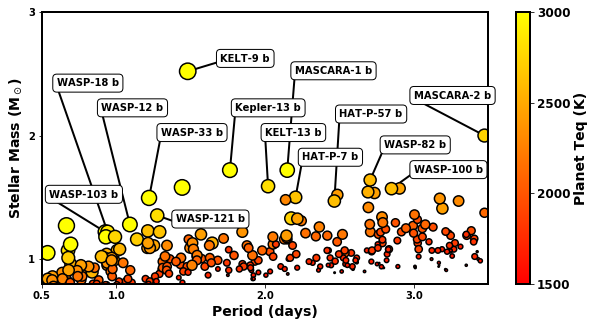

In [24]:
labeldict = {'WASP-18 b':(.6,2.4), 'WASP-121 b':(1.4,1.3), 'WASP-103 b':(0.55,1.5), 'KELT-9 b':(1.7,2.6),\
             'WASP-33 b':(1.3,2.), 'WASP-12 b': (.9, 2.2), 'KELT-13 b':(2,2), 'MASCARA-2 b':(3.,2.3), \
            'MASCARA-1 b': (2.2,2.5), 'HAT-P-7 b': (2.25,1.8), 'WASP-78 b': (1.7,1.45), \
             'OGLE-TR-56 b':(1.1,1.75), 'WASP-82 b':(2.8,1.9), 'WASP-100 b': (3.0,1.7), \
            'HAT-P-57 b': (2.5, 2.15), 'Kepler-13 b':(1.8,2.2)}

y = 'MSTAR'
x = 'PER'
c = 'TEQ'

rcParams['figure.figsize'] = 10, 5

cm = p.cm.get_cmap('hot')

fig, ax = p.subplots()


sizes = (od['TEQ'] - 1500) / 1500. * 200

scax = ax.scatter(od[x], od[y], c=od[c], marker='o', 
          cmap='autumn', edgecolor='k', s=sizes, vmin=1500, vmax=3000, \
          lw = 1.5, zorder=-2)
p.xlabel('Period (days)', fontsize=14, weight='bold')
p.ylabel('Stellar Mass (M$_\odot$)', fontsize=14, weight='bold')

cbar = p.colorbar(scax, ticks=[1500,2000,2500,3000])
cbar.set_label(label='Planet Teq (K)', fontsize=14, weight='bold')
cbar.ax.set_yticklabels([1500,2000,2500,3000], fontsize=12, weight='bold')
p.ylim([0.8,3.])
p.xlim([0.5,3.5])

#ax.set_yscale("log", nonposy='clip')
ax.set_yticks([1,2,3])
ax.set_yticklabels([1,2,3], weight='bold')

ax.set_xticks([0.5,1.0,2.0,3.0])
ax.set_xticklabels([0.5,1.0,2.0,3.0], weight='bold')
p.rc('axes', linewidth=2)
ax.zorder = -10

for planet in od['NAME']:
    planet = get_planet(planet, od)
    if planet['MASS'] < .3: continue
    if planet['NAME'] in ['WASP-78 b','HAT-P-49 b', 'OGLE-TR-56 b']: continue
    if planet['NAME'] == 'KOI-13 b':
        planet['NAME'] = 'Kepler-13 b'
    if planet['PER'] > 3.5: continue
        
    if planet['TEQ'] > 2500.:
        #ax.text(planet[x]+.05, planet[y], planet['NAME'], \
        #      weight='bold', rotation=10, zorder=2, \
        #      bbox=dict(facecolor='w', edgecolor='black', boxstyle='round,pad=0.4', alpha=1, zorder=2))
        try: 
            label = labeldict[planet['NAME']]
            point = (planet[x], planet[y])
        except KeyError: 
            label = (planet[x]+0.05,planet[y])
            point = (planet[x], planet[y])
        print planet['NAME'], label, 
        add_label(ax, point, label, planet['NAME'], color='k', lw=2, zorder=-5)
        
#p.savefig('/home/jacob/Dropbox/plots/vhj_mstar.png', dpi=300, bbox_inches='tight')
p.show()

# Kepler-1171 b, KOI-13 b

In [38]:
print get_planet('Kepler-1171 b', od)

{'A': 0.0291019, 'NAME': 'Kepler-1171 b', 'RSTAR': 1.95, 'PER': 1.44259224, 'R': 0.22800000000000001, 'MASS': 0.0203354, 'TEQ': 3307.175980430517, 'MSTAR': 1.5800000000000001, 'TEFF': 7044.0}
